# Data Screening

Ian Contreras

## Importaciones

### Librerías

In [1]:
#| label: importing-libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import pandas as pd
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima
from arch import arch_model

### Data

In [2]:
#| label: importing-data
df = pd.read_csv(r'..\data\csv\irp.csv', parse_dates=['date'], index_col='date')
returns = df['price_return']
split_date = '2020-12-31'
R_test = df[df.index >= split_date]['price_return'].rolling(
    window=5).std().dropna()

## Análisis Exploratorio.

### Serie Histórica

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.

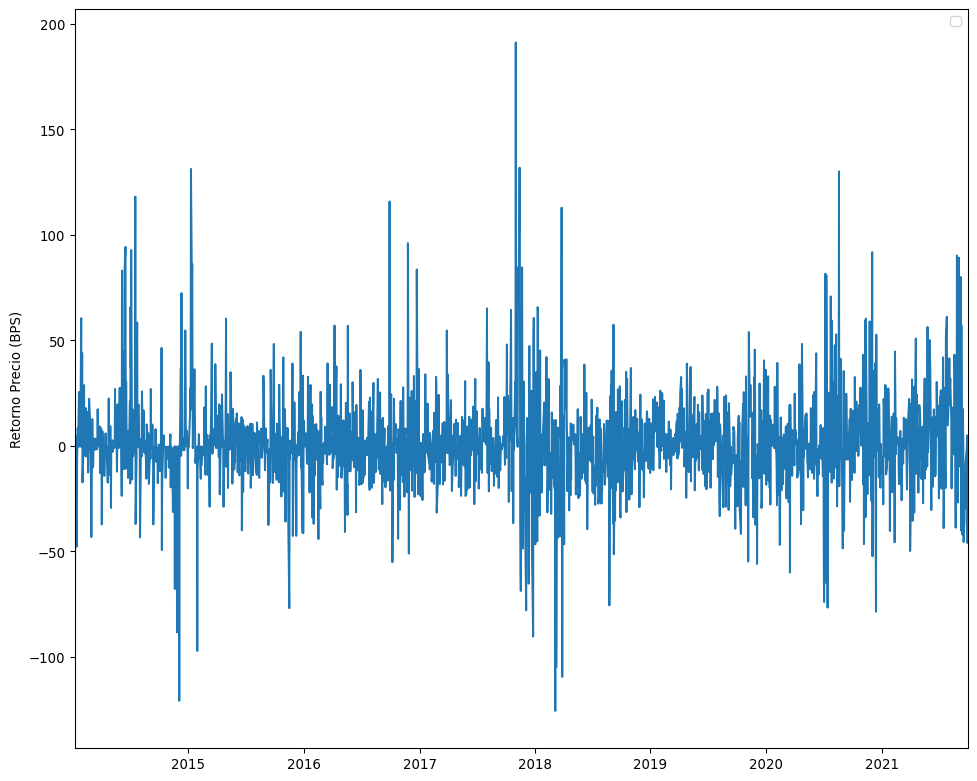

In [3]:
#| label: fig-price-return-series
#| fig-cap: Serie de retornos diarios IRP-GOBIX.
fig, ax = plt.subplots(figsize=(12, 10))
ax.plot(df.index, df['price_return'])
ax.set_ylabel('Retorno Precio (BPS)')
ax.set_xlim([df.index.min(), df.index.max()])
ax.legend()
plt.show()

### Análisis descriptivo de la muestra

In [4]:
#| label: table-descriptive-stats-return
#| fig-cap: Tabla de las estadísticas descriptiva de la serie de retornos
desc_stats = returns.describe()

skewness = returns.skew()
kurtosis = returns.kurtosis()
jb_test = sm.stats.jarque_bera(returns)

descriptive_table = pd.DataFrame({
    'Observations': [int(desc_stats['count'])],
    'Mean': [desc_stats['mean']],
    'Median': [desc_stats['50%']],
    'Std. Dev': [desc_stats['std']],
    'Skewness': [skewness],
    'Kurtosis': [kurtosis],
    'Jarque-Bera': [jb_test[0]],
    'Prob.': [jb_test[1]]
})
descriptive_table

### Ajuste de distribuciones

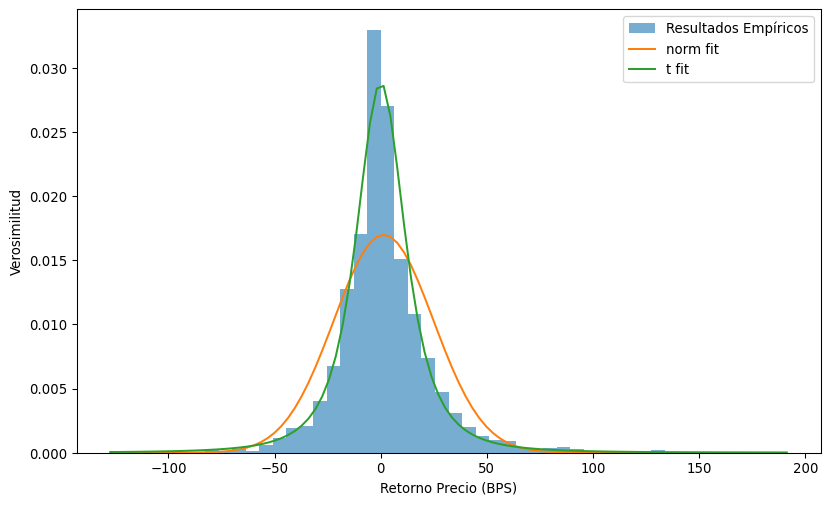

In [5]:
#| label: fig-distribution-fitting
#| fig-cap: Ajuste de distribuciones a los retornos de precio.
distributions = [stats.norm, stats.t]

plt.figure(figsize=(10, 6))
plt.hist(returns, bins=50, density=True, alpha=0.6, label='Resultados Empíricos')

for dist in distributions:
    params = dist.fit(returns)
    x = np.linspace(returns.min(), returns.max(), 100)
    plt.plot(x, dist.pdf(x, *params), label=f'{dist.name} fit')

plt.xlabel('Retorno Precio (BPS)')
plt.ylabel('Verosimilitud')
plt.legend()
plt.show()

### Q-Q plot con respecto a distribución t

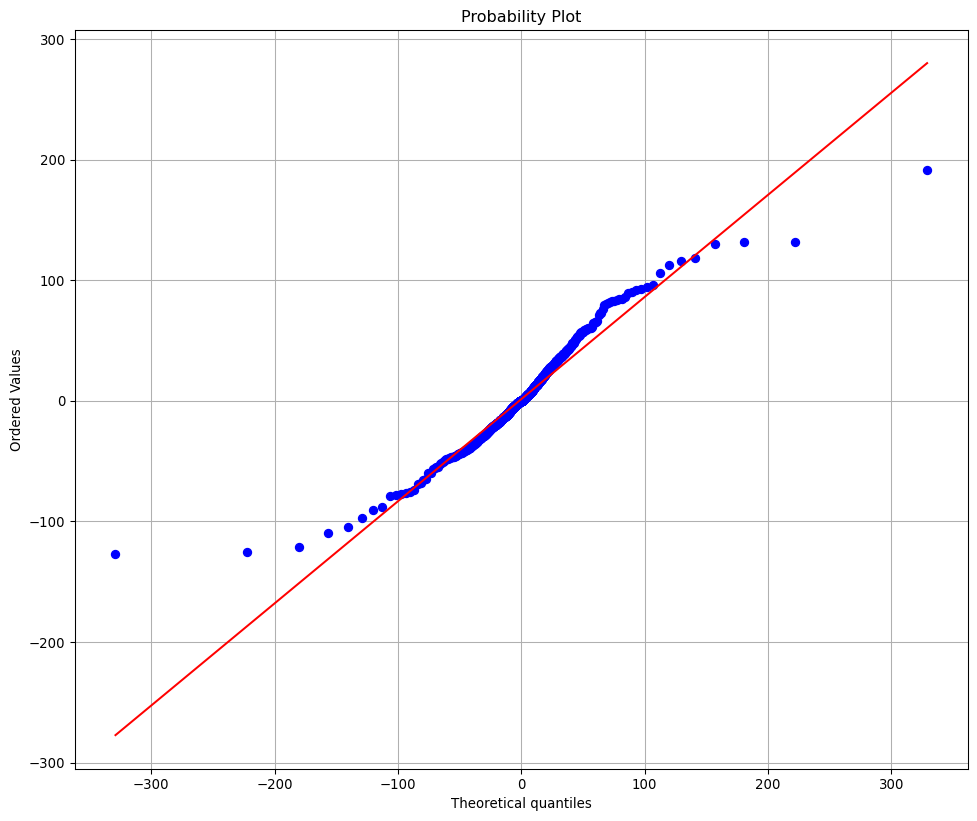

In [6]:
#| label: fig-tqq-plot
#| fig-cap: Q-Q Plot de retornos de precio contra la distribución t.
t_params = stats.t.fit(returns)

fig, ax = plt.subplots(figsize=(12, 10))
stats.probplot(returns, dist="t", sparams=t_params, plot=plt)
plt.grid(True)
plt.show()

### Kolmorov Smirnov test para distribución t

In [7]:
#| label: kolmorov-smirnov
ks_stat, p_value = stats.kstest(returns, 't', args=t_params)
print(f"Kolmogorov-Smirnov statistic: {ks_stat}")
print(f"P-value: {p_value}")

Kolmogorov-Smirnov statistic: 0.028557323574938343
P-value: 0.0827419967953622

### Test de estacionariedad/ robustez

In [8]:
#| label: adf
result = adfuller(returns)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -13.174114850736395
p-value: 1.2332976276203498e-24

### Test de autocorrelación

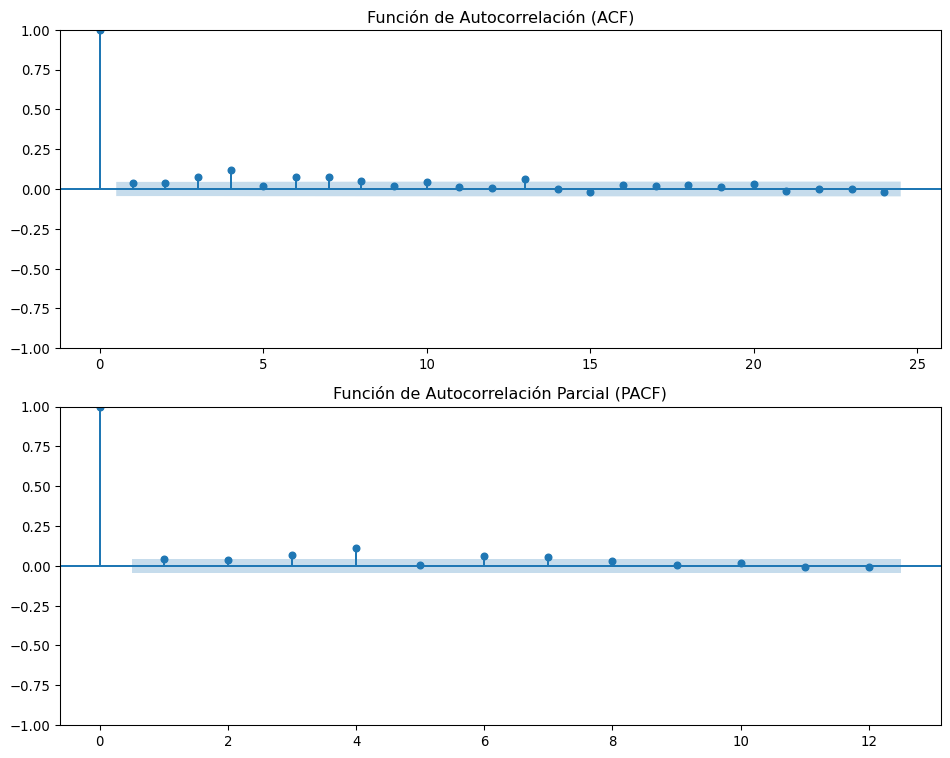

In [9]:
#| label: fig-acf-pacf
#| fig-cap: Función de autocorrelación (ACF) y función de autocorrelación parcial (PACF) de los retornos.
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(returns, lags=24, ax=axes[0])
axes[0].set_title('Función de Autocorrelación (ACF)')

plot_pacf(returns, lags=12, ax=axes[1])
axes[1].set_title('Función de Autocorrelación Parcial (PACF)')

plt.tight_layout()
plt.show()

## Resultados

### Estimación del modelo ARIMA

In [10]:
#| label: arima-model
#| fig-cap: Modelo ARIMA de maxima verosimilitud para la serie de retornos.
model_auto = auto_arima(returns)
model_auto.summary()

Warnings: [1] Covariance matrix calculated using the outer product of gradients (complex-step).

### Estimación del AR-GARCH

In [11]:
#| label: garch-model-fitting
#| fig-cap: Ajuste del modelo Zero-Garch ala serie de retornos
ar = arch_model(returns, mean='Zero', vol='GARCH', dist='t')
res = ar.fit(last_obs=split_date)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 13422.240578344366
Iteration:      2,   Func. Count:     13,   Neg. LLF: 9134.230609110135
Iteration:      3,   Func. Count:     19,   Neg. LLF: 8666.557319151609
Iteration:      4,   Func. Count:     25,   Neg. LLF: 8791.275490419279
Iteration:      5,   Func. Count:     31,   Neg. LLF: 8082.081172585756
Iteration:      6,   Func. Count:     37,   Neg. LLF: 8739.332058159429
Iteration:      7,   Func. Count:     43,   Neg. LLF: 8658.860183258712
Iteration:      8,   Func. Count:     49,   Neg. LLF: 7638.6451038734085
Iteration:      9,   Func. Count:     55,   Neg. LLF: 7626.627815474433
Iteration:     10,   Func. Count:     60,   Neg. LLF: 7624.619361750198
Iteration:     11,   Func. Count:     65,   Neg. LLF: 7623.76815711753
Iteration:     12,   Func. Count:     70,   Neg. LLF: 7623.223103893486
Iteration:     13,   Func. Count:     75,   Neg. LLF: 7623.048366501091
Iteration:     14,   Func. Count:     80,   Neg. LLF: 7622.9986

### Resultados del AR-GARCH

In [12]:
#| label: garch-model
#| fig-cap: Modelo Zero-Garch de la serie de retornos
res.summary()

Covariance estimator: robust

### Residuos del AR-GARCH

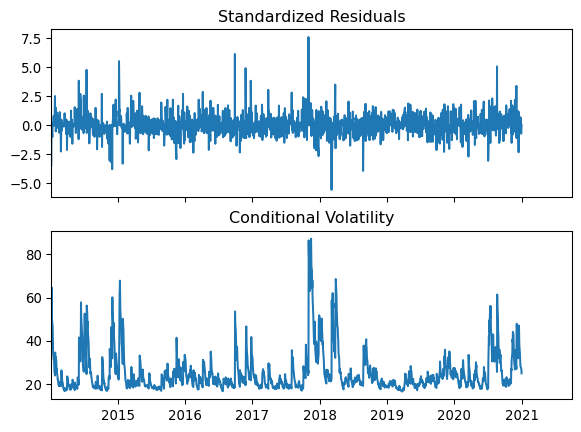

In [13]:
#| label: fig-garch-residuals
#| fig-cap: Residuos del modelo AR-GARCH.
fig = res.plot()

### Residuos contra volatilidad condicional

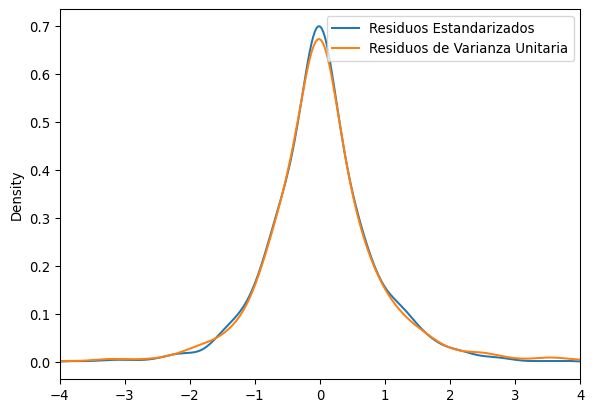

In [14]:
#| label: fig-residuals-vs-volatility
#| fig-cap: Residuos contra la volatilidad condicional del AR-GARCH.
std_resid = res.resid / res.conditional_volatility
unit_var_resid = res.resid / res.resid.std()
df = pd.concat([std_resid, unit_var_resid], axis=1)
df.columns = ["Residuos Estandarizados", "Residuos de Varianza Unitaria"]
subplot = df.plot(kind="kde", xlim=(-4, 4))

## Evaluación Retrospectiva (Backtesting)

### Conversion de varianza predicha.

In [15]:
#| label: forecast
forecasts = res.forecast(horizon=1)
forecasted_std = np.sqrt(forecasts.variance)
forecasted_std = forecasted_std[forecasted_std.index >
                                split_date].loc[R_test.index, 'h.1']

### MAPE del modelo

In [16]:
#| label: mape
def MAPE(actual, predicted):
    actual_std = actual.rolling(window=5).std().dropna()
    return np.mean(np.abs((actual_std - predicted) / actual_std)) * 100

mape_value = MAPE(R_test, forecasted_std)
print(f"MAPE on Test Set (based on moving std): {mape_value:.2f}%")

MAPE on Test Set (based on moving std): 739.70%

### Predichos vs Actuales Plot-Backtested

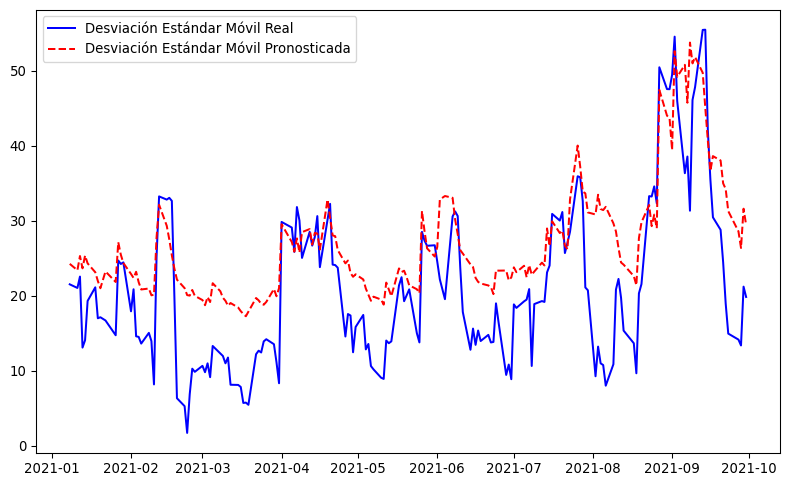

In [17]:
#| label: fig-predicted-vs-actual-backtest
#| fig-cap: Desviación Estándar Móvil Real vs Pronosticada - Modelo Zero-GARCH
plt.figure(figsize=(10, 6))
plt.plot(R_test.index, R_test,
         label='Desviación Estándar Móvil Real', color='blue')
plt.plot(forecasted_std.index,
         forecasted_std, label='Desviación Estándar Móvil Pronosticada', color='red', linestyle='--')
ax.set_xlim([forecasted_std.index.min(), forecasted_std.index.max()])
plt.legend()
plt.show()